In [1]:
from pytoshload import toshload as tl
from pytoshload import ramcode as rc

## Code Patching

The following will patch my specific REVD firmware file.

In [1342]:
f = open(r"DE92-02439D FW.bin", "rb")
flash_data = f.read()
f.close()
flash_data = list(flash_data)
print(len(flash_data))

131072


In [1343]:
def patch(addr, s):
    addr -= 0xfe0000
    data = [int(a,16) for a in s.split()]
    end = len(data) + addr
    flash_data[addr:end] = data

### Patch for Monitor Code

In [1344]:
#Patches code to setup the other UART as well
code_setup = """
f1 01 02 00 14       
f1 02 02 00 29       
f1 05 02 00 40       
f1 03 02 00 46       
f1 04 02 00 08       
f1 09 02 00 00       
f1 0a 02 00 29       
f1 0d 02 00 40       
f1 0b 02 00 46       
f1 0c 02 00 08  
f1 08 02 00 ac
0e                   
"""
patch(0xffb3a0,code_setup)

In [1345]:
#Patches code to jump to above code
code_jump_to_setup = "1b a0 b3 ff"
patch(0xfe7b3c, code_jump_to_setup)

In [1346]:
code_rxcallint = """3e                   
3d                   
3c                   
3b                   
3a                   
39                   
38                   
1D 82 E0 FF
58                   
59                   
5a                   
5b                   
5c                   
5d                   
5e   
07
"""

patch(0xffdf40, code_rxcallint)

code_txcallint = """3e                   
3d                   
3c                   
3b                   
3a                   
39                   
38                   
1D 20 E0 FF
58                   
59                   
5a                   
5b                   
5c                   
5d                   
5e                   
07                   
"""
patch(0xffe000, code_txcallint)

patch(0xffffb0, "40 df ff 00") #rx interrupt
patch(0xffffb4, "00 e0 ff 00") #tx interrupt

In [1347]:
code_tx_interrupt = """c9 a8
c1 1e 21 3f 0e
6f 19
0
c1 1e 21 21
d8 12
f1 02 21 31
c3 07 e4 e0 21
f1 08 02 41
c1 1e 21 61
0e
f1 1e 21 00 00
0e
"""
patch(0xffe020, code_tx_interrupt)

code_rx_interrupt = """
f1 09 02 cb
66 0b
0
c1 08 02 21
f1 20 21 00 00
0e
f1 09 02 ca
66 0b
0
c1 08 02 21
f1 20 21 00 00
0e
f1 09 02 cc
66 0a
c1 08 02 21
f1 20 21 00 00
0e
c1 20 21 21
c9 8b
d9 12
f1 10 21 32
c1 08 02 21
f3 07 e8 e4 41
c1 20 21 61
c1 20 21 3f 0c
b0 f3
f1 20 21 00 00
1e 46 00
0e 
"""
patch(0xffe050, code_rx_interrupt)

code_rx_tx = """e1 12 21 20
a0 20
f1 04 21 60
f1 08 02 00 d0
0e"""
patch(0xffe0f0, code_rx_tx)

#Enable UART interrupt
patch(0xfe7bc7, "33")

### Patch for Updated Display and Logic

In [1348]:
#patch(0xff1723, "01")
#patch(0x0ff168a, "01")

#patch(0xff1683, "68")
#patch(0xff171b, "78")

#patch(0xff172a, "68")
#patch(0xff1761, "78")

patch(0xff1772, "00") #<-- No beeps, but display stops updating still
patch(0xff1723, "01") #Weird long beep that won't stop, but display updates

#patch(0xfe8802, "00 00") #<-- Causes display to show set temp only

#patch(0xfe8866, "68") #<-- Displays 150F only (or maybe set?). 12a8 tracks actual temp even falling)
#patch(0xfe8866, "00 00") #<-- Works more normally, but still showed max only. 12a8 tracks max only.

#patch(0xfe885f, "68 33") # Jump to 0xfe8894

patch(0xfe885f, """dc 8b
f2 a8 12 00 53
f1 0a 12 c8
66 44
db c8 0b 00
68 3e
""")

#patch(0xfe885f, "68") #<-- Displays 150F only. 12a8 tracks actual temp (even falling)
#patch(0xfe885f, "00 00") <-- Works more normally, but still showed max only. 12a8 tracks max only.

#patch(0xfe886d, "68") #<-- Works more normally, but still showed max only. 12a8 tracks max only.
#patch(0xfe886d, "00 00") #<-- Works more normally, but still showed max only. 12a8 tracks max only.

#patch(0xfe8878, "68") #<-- Works more normally, but still showed max only. 12a8 tracks max only.
#patch(0xfe8878, "00 00") #<-- Works more normally, but still showed max only. 12a8 tracks max only.

#patch(0xfe887f, "68") #<-- Works more normally, but still showed max only. 12a8 tracks max only.
#patch(0xfe887f, "00 00") #<-- Works more normally, but still showed max only. 12a8 tracks max only.

#patch(0xfe8886, "00 00") #<-- Works more normally, but still showed max only. 12a8 tracks max only.
#patch(0xfe8886, "68") #<-- Works more normally, but still showed max only. 12a8 tracks max only.

# patch(0xfe877d, "68") #Same as above
# patch(0xfe877d, "00 00") #<-- Shows set temp only

#patch(0xfe8783, "68")#normal per above
#patch(0xfe8783, "00 00")#normal per above

### Write Patch to Disk

Use the flash program to actually program in the file.

In [1349]:
f = open(r"DE92-02439D FW PATCHED.bin", "wb")
f.write(bytes(flash_data))
f.close()
print(len(flash_data))

131072


In [1350]:
ser.close()

## Monitor Program

This requires the monitor code above be flashed into the oven.

In [2]:
import serial
import time
ser = serial.Serial('COM4', 38400, timeout=0.5)

In [3]:
import time
def reset_function(boot_mode=True):
    #RTS/DTR logic levels "backwards" - watch out!!
    ser.rts = True
    if boot_mode:
        ser.dtr = True
    else:
        ser.dtr = False
    time.sleep(0.1)
    ser.rts = False
    time.sleep(1)

reset_function(False)

In [4]:
while len(ser.read(32) ) == 0:
    ser.write(b"\x00")

In [5]:
pl = [0,0,0,0,0,0,0,0,0,0,0,0,0]

In [6]:
import struct

def get_2shorts(addr):
    pl = b'\x00\x00' + struct.pack("<l", addr) + b'\x00\x00\x00\x00\x00\x00\x00'
    ser.write(pl)
    r = ser.read(15)
    lower = struct.unpack("<H", r[3:5])[0]
    upper = struct.unpack("<H", r[5:7])[0]
    return (lower, upper)

In [7]:
def print_addr(addr):
    print("%04x"%addr)
    lower, upper = get_2shorts(addr)
    print("  %02x %d"%(lower,lower))
    print("  %02x %d"%(upper,upper))

### Examples of Finding Interesting Addresses

In [8]:
print_addr(0x1248)
print_addr(0x120a)

1248
  65 101
  37 55
120a
  00 0
  00 0


In [1264]:
print_addr(0x1113)

1113
  00 0
  00 0


In [841]:
print_addr(0x123E)

123e
  10e 270
  b0 176


In [302]:
#123e = ADC readings
#1248 = temp (F)
#111c = set temp (F)
#120a = heater on

1675989442.7953417

In [ ]:
#addrs = [0x1200, 0x1342, 0x110E, 0x11F6, 0x11F8, 0x11E4, 0x11FA, 0x110A]

#addrs = [0x1113, 0x110a, 0x1213, 0x1117, 0x10c0, 0x11ec, 0x1216, 0x11ea, 0x11ee, 0x11f0, 0x1120, 0x1248]

addrs = [0x12A8, 0x1248, 0x122A, 0x1232]

addr_data_list = [[] for _ in addrs]

def get_data(addr):
    return get_2shorts(addr)[0]

while True:
    time.sleep(1)
    
    for i,addr in enumerate(addrs):
        data = get_data(addr)
        addr_data_list[i].append(data)
        
        new = addr_data_list[i][-1]
        if len(addr_data_list[i]) > 1:
            old = addr_data_list[i][-2]
            if new != old:
                print("%04x: change %2x -> %2x (%d)"%(addrs[i], old, new, new))
        else:
            print("%04x: %2x (%d)"%(addrs[i], new, new))


In [ ]:
while True:
    print("Checking")
    for addr in range(0x1000, 0x2100):
        #temp = get_data(0x1248)
        if get_data(addr) == 335:#temp-1:
            print("Candidate: %04x"%addr)

The following will brute force interesting address locations. Requires disassembled firmware file. You can then print when the addresses have changing data.

In [667]:
f = open(r"DE92-02439D FW Disassembly.txt", "r")
lines = f.readlines()
f.close()

In [ ]:
addr_list = []

for line in lines:
    if line[41:].startswith(r"CPB     (0x1"):
        addr = int(line[50:56], 16)
        if addr not in addr_list:
            addr_list.append(addr)

#Remove some of the addresses that aren't very interesting it seems (just noisey)
addr_list.remove(0x11d0)
addr_list.remove(0x11c6)
addr_list.remove(0x11c4)
addr_list.remove(0x1090)
addr_list.remove(0x1270)
addr_list.remove(0x1092)
addr_list.remove(0x10be)
addr_list.remove(0x1242)
addr_list.remove(0x1089)
addr_list.remove(0x11da)
addr_list.remove(0x11f6)
addr_list.remove(0x11f8)
addr_list.remove(0x11e4)

#Pressing buttons does these
#107e: change 1800 -> 1b00
#13d6: change  0 ->  4
#1108: change  0 ->  1
#1117: change  0 ->  8
#11a8: change  0 ->  1
#1115: change  0 ->  8
#1272: change  1 ->  0
#1232: change  0 -> 503
#109a: change 701 -> 801
#109b: change  7 ->  8
#1220: change  0 ->  1
#1116: change  0 -> 800
#107e: change 1b00 -> ec00
#13d6: change  4 ->  0

addr_list.remove(0x107e)
addr_list.remove(0x13d6)
addr_list.remove(0x1108)
addr_list.remove(0x1117)
addr_list.remove(0x11a8)
addr_list.remove(0x1115)
addr_list.remove(0x1272)
addr_list.remove(0x1232)
addr_list.remove(0x109a)
addr_list.remove(0x109b)
addr_list.remove(0x1220)
addr_list.remove(0x1116)

print(addr_list)

In [716]:
addrs = addr_list

In [941]:
#print_addr(0x1113)
#print_addr(0x1107)
#print_addr(0x111C)
#print_addr(0x1125)
#print_addr(0x1372)
#print_addr(0x1376)
#print_addr(0x1374)
#print_addr(0x1224)
#print_addr(0x1233)
#print_addr(0x1232)
#print_addr(0x1248)
#print_addr(0x120A)
#print_addr(0x1206)
#print_addr(0x13D4)

addrs = [0x1113, 0x1200, 0x1342, 0x133a, 0x110E, 0x11F6, 0x11F8, 0x11E4, 0x11FA, 0x110A]

for addr in addrs:
    print_addr(addr)


1113
  00 0
  f08 3848
1200
  00 0
  00 0
1342
  00 0
  00 0
133a
  00 0
  00 0
110e
  00 0
  00 0
11f6
  00 0
  00 0
11f8
  00 0
  00 0
11e4
  00 0
  05 5
11fa
  00 0
  00 0
110a
  01 1
  00 0


In [ ]:
#next to check - what is 0x13D4?

### Examples of Reading Data Series

In [9]:
import time
start = time.time()

time_series = []
temp_series = []
heat_series = []


while True:
    time.sleep(2)
    data = get_2shorts(0x1248)
    time_series.append(time.time() - start)
    temp_series.append(data[0])
    
    data2 = get_2shorts(0x120a)
    heat_series.append(data2[0])
    
    
    print("%d %d"%(data[0], data2[0]))   

72 0
72 0
73 0
73 0
77 0
77 0
71 0
45 1
45 1
45 1
45 1
45 1
46 1
46 1
46 1
46 1
46 1
47 1
48 1
49 1
50 1
58 1
51 1
52 1
54 1
55 1
56 1
58 1
59 1
60 1
63 1
64 1
66 1
68 1
70 1
73 1
75 1
77 1
79 1
82 1
85 1
87 1
90 1
92 1
95 1
98 1
100 1
103 1
106 1
109 1
111 0
114 1
118 1
120 1
123 1
126 1
129 1
132 1
135 1
138 1
140 1
144 1
146 1
150 1
153 1
164 1
159 1
162 1
165 1
168 1
170 1
174 1
176 1
180 1
182 1
185 1
188 1
192 1
195 1
197 1
200 1
202 1
205 1
208 1
211 1
214 1
216 1
219 1
222 1
225 1
227 1
230 1
233 1
235 1
238 1
240 1
243 1
246 1
248 1
250 1
253 1
255 1
258 1
260 1
263 1
265 1
268 1
270 1
273 1
278 0
277 1
280 1
282 1
284 1
286 1
287 1
290 1
292 1
294 1
296 1
298 1
300 1
302 1
304 1
315 1
308 1
310 1
313 1
315 1
316 1
319 1
321 1
323 1
325 1
327 1
329 1
331 1
333 1
335 1
337 1
339 1
340 1
343 1
345 1
347 1
350 1
356 1
358 1
360 1
372 0
374 0
375 0
377 0
379 0
381 0
383 0
384 0
385 0
387 0
387 0
389 0
389 0
390 0
390 0
391 0
391 0
392 0
392 0
393 0
393 0
393 0
393 0
392 0
392 0
39

KeyboardInterrupt: 

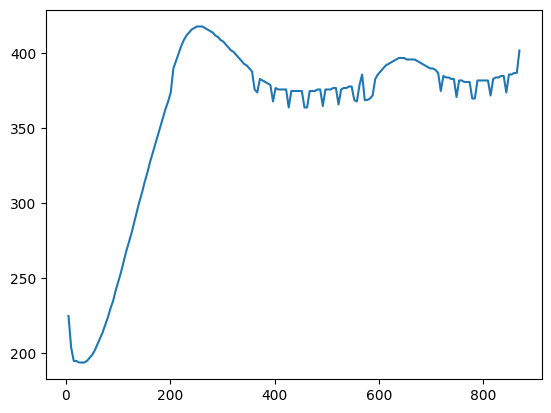

In [307]:
import matplotlib.pylab as plt
import numpy as np

plt.plot(time_series, data_series)

#np.save("test_feb9_time_f.npy", time_series)
#np.save("test_feb9_data_f.npy", data_series)

Text(0, 0.5, 'Temp (F)')

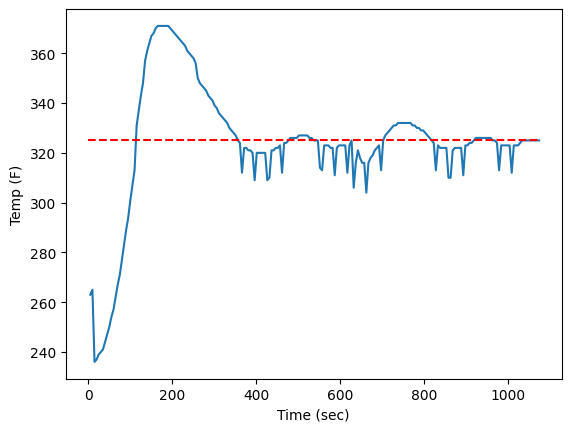

In [391]:
import matplotlib.pylab as plt
import numpy as np

plt.plot(time_series, data_series)
plt.plot([0, time_series[-1]], [325, 325], 'r--')

plt.xlabel('Time (sec)')
plt.ylabel('Temp (F)')

#np.save("test_feb9_time_f_colderstart.npy", time_series)
#np.save("test_feb9_data_f_colderstart.npy", data_series)

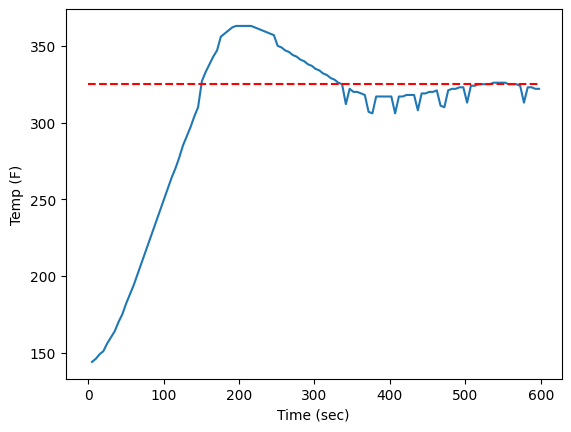

In [408]:
import matplotlib.pylab as plt
import numpy as np

plt.plot(time_series, data_series)
plt.plot([0, time_series[-1]], [325, 325], 'r--')

plt.xlabel('Time (sec)')
plt.ylabel('Temp (F)')

#np.save("test_feb9_time_f_colderstart.npy", time_series)
#np.save("test_feb9_data_f_colderstart.npy", data_series)

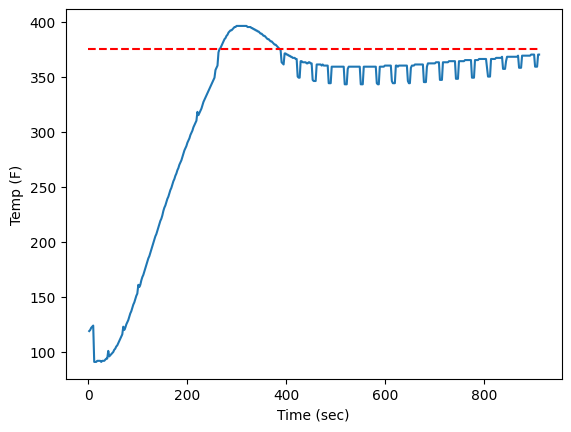

In [580]:
import matplotlib.pylab as plt
import numpy as np

plt.plot(time_series, data_series)
plt.plot([0, time_series[-1]], [375, 375], 'r--')

plt.xlabel('Time (sec)')
plt.ylabel('Temp (F)')

#np.save("test_feb9_time_f_colderstart_375F.npy", time_series)
#np.save("test_feb9_data_f_colderstart_375F.npy", data_series)

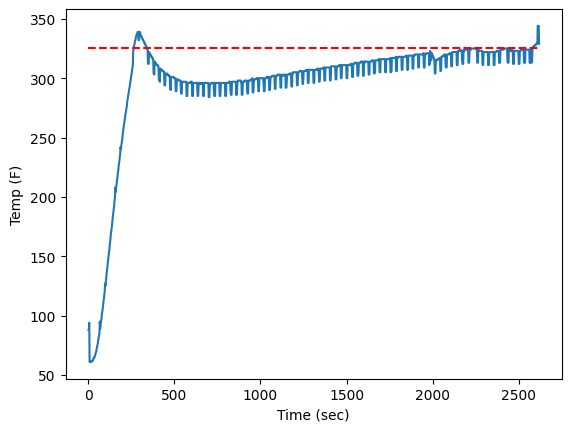

In [591]:
import matplotlib.pylab as plt
import numpy as np

plt.plot(time_series, temp_series)
plt.plot([0, time_series[-1]], [325, 325], 'r--')

plt.xlabel('Time (sec)')
plt.ylabel('Temp (F)')

#np.save("test_feb10_time_f_coldstart_wload_325F.npy", time_series)
#np.save("test_feb10_data_f_coldstart_wload_325F.npy", temp_series)

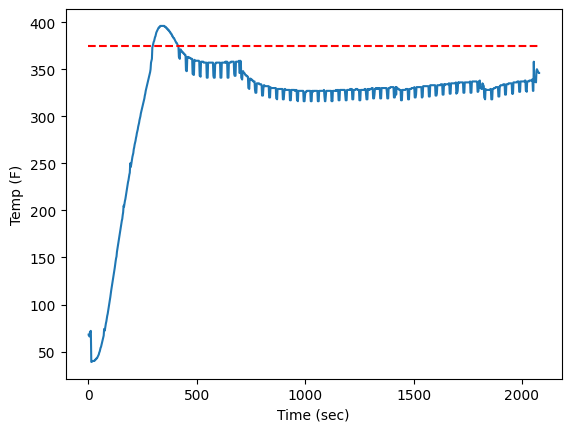

In [1282]:
import matplotlib.pylab as plt
import numpy as np

plt.plot(time_series, temp_series)
plt.plot([0, time_series[-1]], [375, 375], 'r--')

plt.xlabel('Time (sec)')
plt.ylabel('Temp (F)')

#np.save("test_feb13_time_f_coldstart_wshepherdspie_375F.npy", time_series)
#np.save("test_feb13_data_f_coldstart_wshepherdspie_375F.npy", temp_series)
#np.save("test_feb13_data_f_coldstart_wshepherdspie_375F.npy", heat_series)

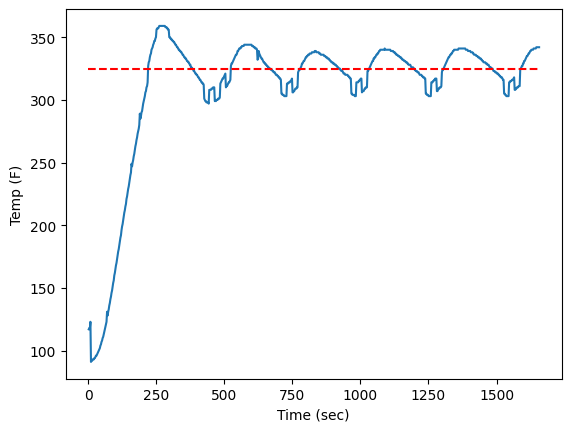

In [1312]:
import matplotlib.pylab as plt
import numpy as np

plt.plot(time_series, temp_series)
plt.plot([0, time_series[-1]], [325, 325], 'r--')

plt.xlabel('Time (sec)')
plt.ylabel('Temp (F)')

#np.save("test_feb14_time_f_coldstart_empty_hackedworkingdisplay_325F.npy", time_series)
#np.save("test_feb14_time_f_coldstart_empty_hackedworkingdisplay_325F.npy", temp_series)
#np.save("test_feb14_time_f_coldstart_empty_hackedworkingdisplay_325F.npy", heat_series)

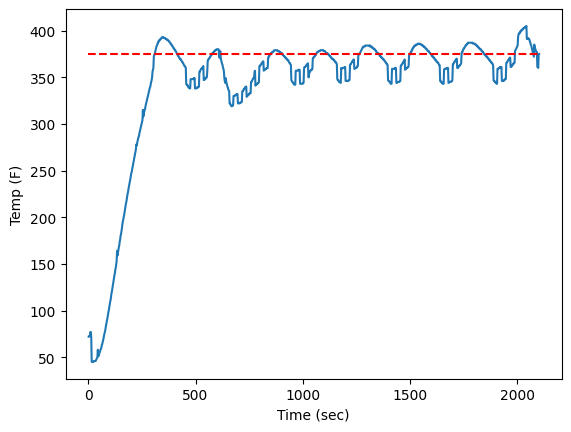

In [10]:
import matplotlib.pylab as plt
import numpy as np

plt.plot(time_series, temp_series)
plt.plot([0, time_series[-1]], [375, 375], 'r--')

plt.xlabel('Time (sec)')
plt.ylabel('Temp (F)')

#np.save("test_feb24_time_f_coldstart_wshepherdspie_375F.npy", time_series)
#np.save("test_feb24_data_f_coldstart_wshepherdspie_375F.npy", temp_series)
#np.save("test_feb24_data_f_coldstart_wshepherdspie_375F.npy", heat_series)

In [1358]:
ser.close()